### Package Versions

- **Python version**: `3.9.13`
- **NumPy version**: `1.23.5`
- **Matplotlib version**: `3.4.2`
- **SciPy version**: `1.9.1`
- **Pandas version**: `1.5.3`



In [1]:
# Import the necessary libraries
import numpy as np # For calculations
import matplotlib.pyplot as plt # For plotting 
from scipy.optimize import curve_fit # For curve fitting
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator) #make plot nicer
import pandas as pd # For reading the data
import os #For flexible path way to data

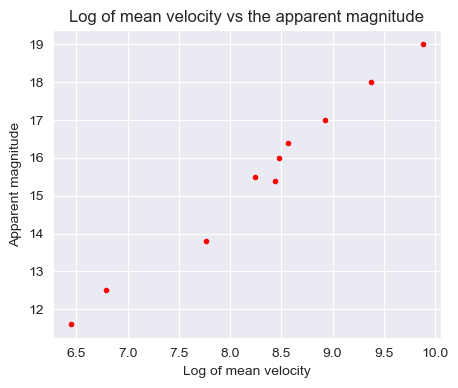

In [70]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the data file in a flexible way
# This allows the code to work regardless of the current working directory
root_folder = os.getcwd()  # Get the current working directory
data_file = os.path.join(root_folder, 'hubbleHumasonData.dat')  # Define the path to the data file

# Read the data file using the pandas package
# The 'delim_whitespace=True' argument specifies that whitespace is used as the delimiter
data = pd.read_csv(data_file, delim_whitespace=True)

# Extract the x (log velocity) and y (apparent magnitude) values from the data
log_v = np.log(data['v'].values)  # Compute the natural log of velocity values
N = data['N'].values              # Extract the number of samples, if needed later
m = data['m'].values              # Extract the apparent magnitude values

# Plot the data
plt.figure(figsize=(5, 4))  # Set the figure size for the plot
plt.scatter(log_v, m, color='red', marker=".")  # Scatter plot of log(velocity) vs magnitude
plt.xlabel('Log of mean velocity')              # Label for the x-axis
plt.ylabel('Apparent magnitude')                # Label for the y-axis
plt.title('Log of mean velocity vs the apparent magnitude')  # Title for the plot
plt.show()  # Display the plot


So from the plot of the data it is obvious that the data set has linear relation. 

# Question 3: Overview and Explanation

In question 3, we aim to estimate parameters of a model using **Bayesian inference**, focusing on understanding the **log-likelihood**, **posterior distribution**, and the role of **Markov Chain Monte Carlo (MCMC)** methods. These concepts are essential in Bayesian analysis for updating our beliefs about parameter values based on observed data.

## Log-Likelihood Function

The **log-likelihood** function measures how likely the observed data is given specific parameter values. It is defined as the logarithm of the likelihood function, which itself represents the probability of the data given the parameters. Mathematically, for a model parameter $\theta$ and observed data $x$, the likelihood function $L(\theta | x)$ is given by:

$$
L(\theta | x) = P(x | \theta)
$$

The **log-likelihood** is then defined as:

$$
\log L(\theta | x) = \sum_{i=1}^{n} \log P(x_i | \theta)
$$

where:
- $n$ is the number of observations,
- $\theta$ represents the model parameters,
- $x_i$ is each individual data point in $x$.

The log-likelihood function simplifies calculations, particularly when dealing with a large number of observations, because it turns products of probabilities into sums. By maximizing the log-likelihood, we can find the **maximum likelihood estimates (MLE)** for the model parameters, which are the values of $\theta$ that make the observed data most probable.

## Posterior Distribution

The **posterior distribution** combines prior beliefs about the parameters with the information from the observed data. This combination is done using Bayes' theorem, which is expressed as:

$$
P(\theta | x) = \frac{P(x | \theta) P(\theta)}{P(x)}
$$

where:
- $P(\theta | x)$ is the posterior distribution, representing our updated beliefs about $\theta$ after observing the data,
- $P(x | \theta)$ is the likelihood of the data given $\theta$,
- $P(\theta)$ is the prior distribution, reflecting our initial beliefs about $\theta$ before seeing the data,
- $P(x)$ is the **marginal likelihood** (or evidence), which normalizes the posterior distribution.

The posterior distribution gives a complete picture of the likely values of $\theta$, not just a single point estimate, incorporating uncertainty in our parameter estimates based on both prior knowledge and observed data.

## Markov Chain Monte Carlo (MCMC)

When it is difficult to compute the posterior distribution analytically (often due to complex models or high-dimensional parameter spaces), we can use **Markov Chain Monte Carlo (MCMC)** methods. MCMC methods approximate the posterior distribution by generating samples from it, even when direct computation is impractical.

### How MCMC Works

MCMC methods construct a **Markov chain** of samples that eventually approximate the posterior distribution. A Markov chain is a sequence of samples where each sample only depends on the previous one, creating a path that "walks" through the parameter space. Common MCMC algorithms include:

- **Metropolis-Hastings**: This algorithm proposes new samples and accepts or rejects them based on a probability related to the posterior. It tends to accept moves that improve the likelihood and occasionally accepts worse moves to avoid getting trapped in local maxima.

- **Gibbs Sampling**: This algorithm samples each parameter sequentially, given the current values of all other parameters. It works well when each parameter’s conditional distribution is known.

### Why MCMC is Useful

MCMC methods allow us to approximate the posterior distribution with a set of samples. From these samples, we can estimate:
- **Point estimates** of parameters (e.g., using the mean or median of the samples),
- **Uncertainty** (e.g., using the spread of the samples),
- **Credible intervals**, which provide a Bayesian equivalent to confidence intervals.

In the context of question 3, MCMC helps us draw samples from the posterior distribution, allowing us to estimate parameters and quantify uncertainty in cases where an analytical solution is difficult or impossible.


In [71]:
# Parameters and MCMC settings
iterations = 100000  # Total number of MCMC iterations
a_current, b_current = 0.2, 0.9  # Initial starting values for parameters a and b
proposal_width_a = 0.2  # Proposal width for sampling new values of a
proposal_width_b = 0.04  # Proposal width for sampling new values of b
a_values, b_values = [a_current], [b_current]  # Lists to store sampled values of a and b

# Define the likelihood function, assuming Gaussian errors
def likelihood(a, b, N, m, log_v):
    """
    Calculates the Gaussian log-likelihood for given values of parameters a and b.
    Assumes errors in log velocity (log_v) follow a Gaussian distribution.

    Parameters:
    - a: intercept parameter
    - b: slope parameter
    - N: number of samples (used for weighting)
    - m: apparent magnitude
    - log_v: observed log of velocity

    Returns:
    - Log-likelihood value as a negative half sum of squared differences
    """
    log_v_pred = a + b * m  # Predicted log velocity based on current a and b
    return -0.5 * np.sum(N * (log_v - log_v_pred) ** 2)  # Calculate log-likelihood

# MCMC loop for parameter estimation
log_likelihoods = []  # List to store log-likelihoods for each sampled pair (a, b)
for i in range(iterations):
    # Propose new values for a and b from normal distributions centered on current values
    a_proposed = np.random.normal(a_current, proposal_width_a)
    b_proposed = np.random.normal(b_current, proposal_width_b)

    # Calculate the likelihoods for current and proposed values of (a, b)
    current_likelihood = likelihood(a_current, b_current, N, m, log_v)
    proposed_likelihood = likelihood(a_proposed, b_proposed, N, m, log_v)

    # Metropolis-Hastings acceptance criterion
    acceptance_rate = np.exp(proposed_likelihood - current_likelihood)  # Acceptance probability
    if np.random.rand() < acceptance_rate:  # Accept or reject based on acceptance rate
        a_current, b_current = a_proposed, b_proposed  # Accept proposal if accepted

    # Append the current values of a and b to the lists (whether accepted or not)
    a_values.append(a_current)
    b_values.append(b_current)
    log_likelihoods.append(current_likelihood)  # Store the log-likelihood of current parameters


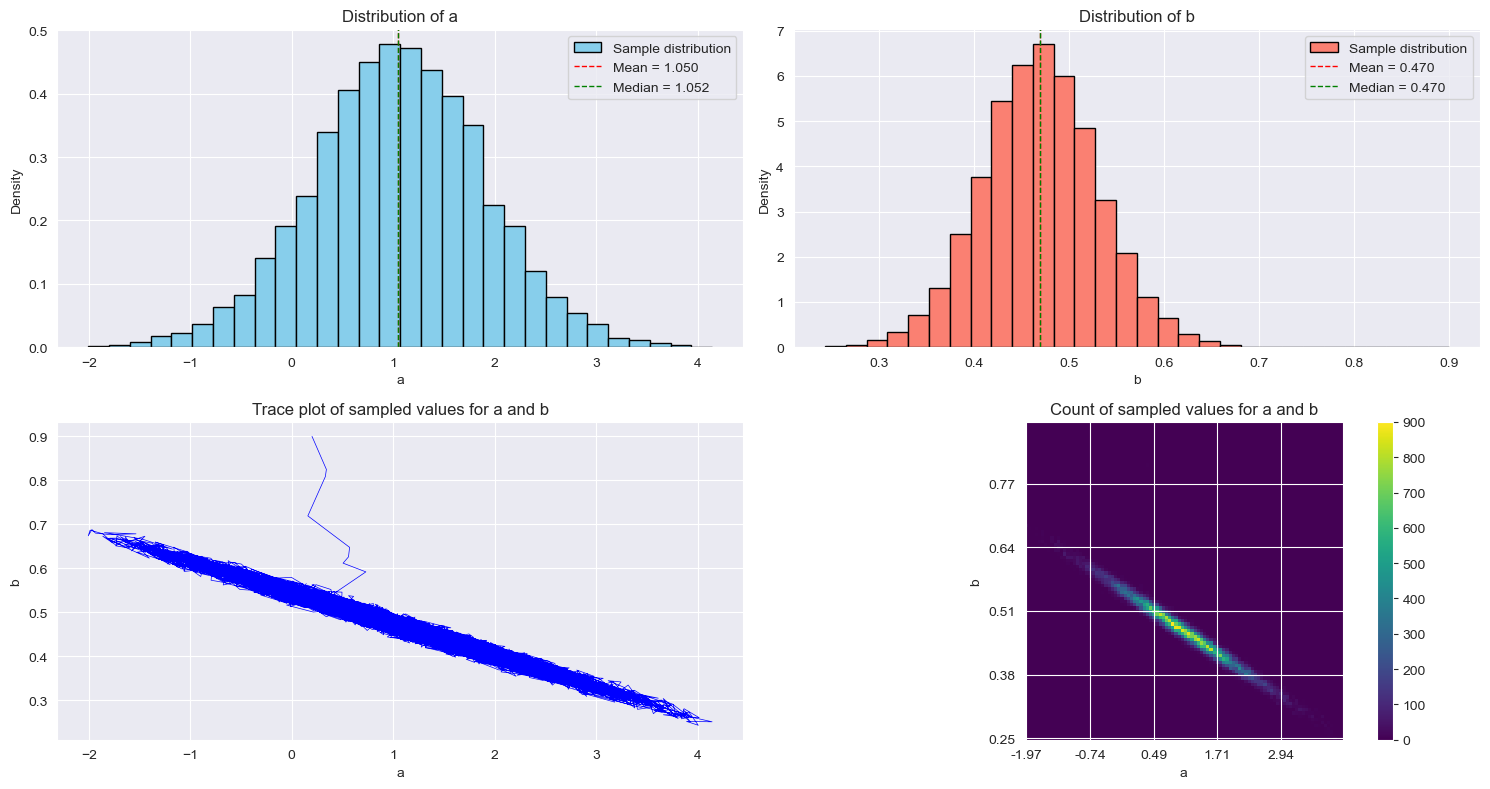

Mean of a: 1.050
Median of a: 1.052
95% credible interval for a: [-0.65531055  2.73151309]
Mean of b: 0.470
Median of b: 0.470
95% credible interval for b: [0.34891378 0.59378205]


In [74]:
# Plotting the sample distributions for parameters a and b
plt.figure(figsize=(15, 8))  # Set the figure size for better visibility of all subplots

# Plot distribution of a
plt.subplot(2, 2, 1)  # Create the first subplot in a 2x2 grid layout
plt.hist(a_values, bins=30, color="skyblue", edgecolor="black", density=True, label="Sample distribution")
# Plot a histogram for 'a_values' with 30 bins; density=True normalizes the histogram

# Calculate and plot mean and median for a_values
a_mean = np.mean(a_values)  # Calculate the mean of 'a_values'
a_median = np.median(a_values)  # Calculate the median of 'a_values'

# Plot vertical lines to mark the mean and median values of 'a'
plt.axvline(a_mean, color='red', linestyle='--', linewidth=1, label=f"Mean = {a_mean:.3f}")
plt.axvline(a_median, color='green', linestyle='--', linewidth=1, label=f"Median = {a_median:.3f}")
plt.xlabel("a")  # Label the x-axis as 'a'
plt.ylabel("Density")  # Label the y-axis as 'Density'
plt.title("Distribution of a")  # Set the title for this subplot
plt.legend()  # Display the legend for mean and median lines

# Plot distribution of b
plt.subplot(2, 2, 2)  # Create the second subplot in a 2x2 grid layout
plt.hist(b_values, bins=30, color="salmon", edgecolor="black", density=True, label="Sample distribution")
# Plot a histogram for 'b_values' with similar settings to 'a_values'

# Calculate and plot mean and median for b_values
b_mean = np.mean(b_values)  # Calculate the mean of 'b_values'
b_median = np.median(b_values)  # Calculate the median of 'b_values'

# Plot vertical lines to mark the mean and median values of 'b'
plt.axvline(b_mean, color='red', linestyle='--', linewidth=1, label=f"Mean = {b_mean:.3f}")
plt.axvline(b_median, color='green', linestyle='--', linewidth=1, label=f"Median = {b_median:.3f}")
plt.xlabel("b")  # Label the x-axis as 'b'
plt.ylabel("Density")  # Label the y-axis as 'Density'
plt.title("Distribution of b")  # Set the title for this subplot
plt.legend()  # Display the legend for mean and median lines

# Plotting the trace plot of a and b
plt.subplot(2, 2, 3)  # Create the third subplot in a 2x2 grid layout
plt.plot(a_values, b_values, color="blue", linewidth=0.5)  # Plot 'a_values' against 'b_values' as a trace plot
plt.xlabel('a')  # Label the x-axis as 'a'
plt.ylabel('b')  # Label the y-axis as 'b'
plt.title("Trace plot of sampled values for a and b")  # Set the title for this subplot

# Plotting a 2D histogram (heatmap) of a and b
plt.subplot(2, 2, 4)  # Create the fourth subplot in a 2x2 grid layout

n_bins = 100  # Define the number of bins for the 2D histogram
hist, xedges, yedges = np.histogram2d(a_values, b_values, bins=n_bins)
# Calculate the 2D histogram of 'a_values' and 'b_values' with specified bins

# Calculate the bin centers for customized ticks
x_centers = (xedges[:-1] + xedges[1:]) / 2  # Calculate bin centers for x-axis
y_centers = (yedges[:-1] + yedges[1:]) / 2  # Calculate bin centers for y-axis

# Display the 2D histogram using imshow with a color map
plt.imshow(hist.T, cmap='viridis', origin='lower')  # Plot the histogram as a heatmap
step = int(n_bins / 5)  # Define the step size for tick labels to avoid overcrowding
plt.xticks(np.arange(0, n_bins, step), np.round(x_centers[::step], 2))  # Set custom x-axis ticks
plt.yticks(np.arange(0, n_bins, step), np.round(y_centers[::step], 2))  # Set custom y-axis ticks
plt.colorbar()  # Add a color bar to indicate the count/intensity of samples
plt.xlabel('a')  # Label the x-axis as 'a'
plt.ylabel('b')  # Label the y-axis as 'b'
plt.title("Count of sampled values for a and b")  # Set the title for this subplot

# Adjust the layout of subplots to avoid overlap
plt.tight_layout()  # Automatically adjust subplot parameters for better layout
plt.show()  # Display the entire figure with all subplots

# Calculate 95% credible intervals for a and b
a_cred_int = np.percentile(a_values, [2.5, 97.5])  # Calculate the 2.5th and 97.5th percentiles for 'a_values'
b_cred_int = np.percentile(b_values, [2.5, 97.5])  # Calculate the 2.5th and 97.5th percentiles for 'b_values'

# Display the mean, median, and 95% credible intervals for both a and b
print(f"Mean of a: {a_mean:.3f}")
print(f"Median of a: {a_median:.3f}")
print(f"95% credible interval for a: {a_cred_int}")

print(f"Mean of b: {b_mean:.3f}")
print(f"Median of b: {b_median:.3f}")
print(f"95% credible interval for b: {b_cred_int}")


The probability of distribution of a and b are normal distribution and we use the mean and median of these distributions to check which one works better in below.
Here we found the confidence interval is quit large so it means that we need more data to make it smaller but I'll continue to use this data set for the following. I want to check if it can effect the results or not.

The bottom left plot shows the trajectory of the parameters in markov-chain and the bottom right shows the same plot but it shows the sample values of each parameters. According to these plot it seems the zig-zag trajectory in bottom left is a transient phase of Markov-chain to the equilibrium cloud. The best answer is the most frequent visited point in the cloud.

R^2 (Mean): 0.9810041521554977
R^2 (Median): 0.9813896841575784
R^2 (Max Likelihood): 0.9822885251813693


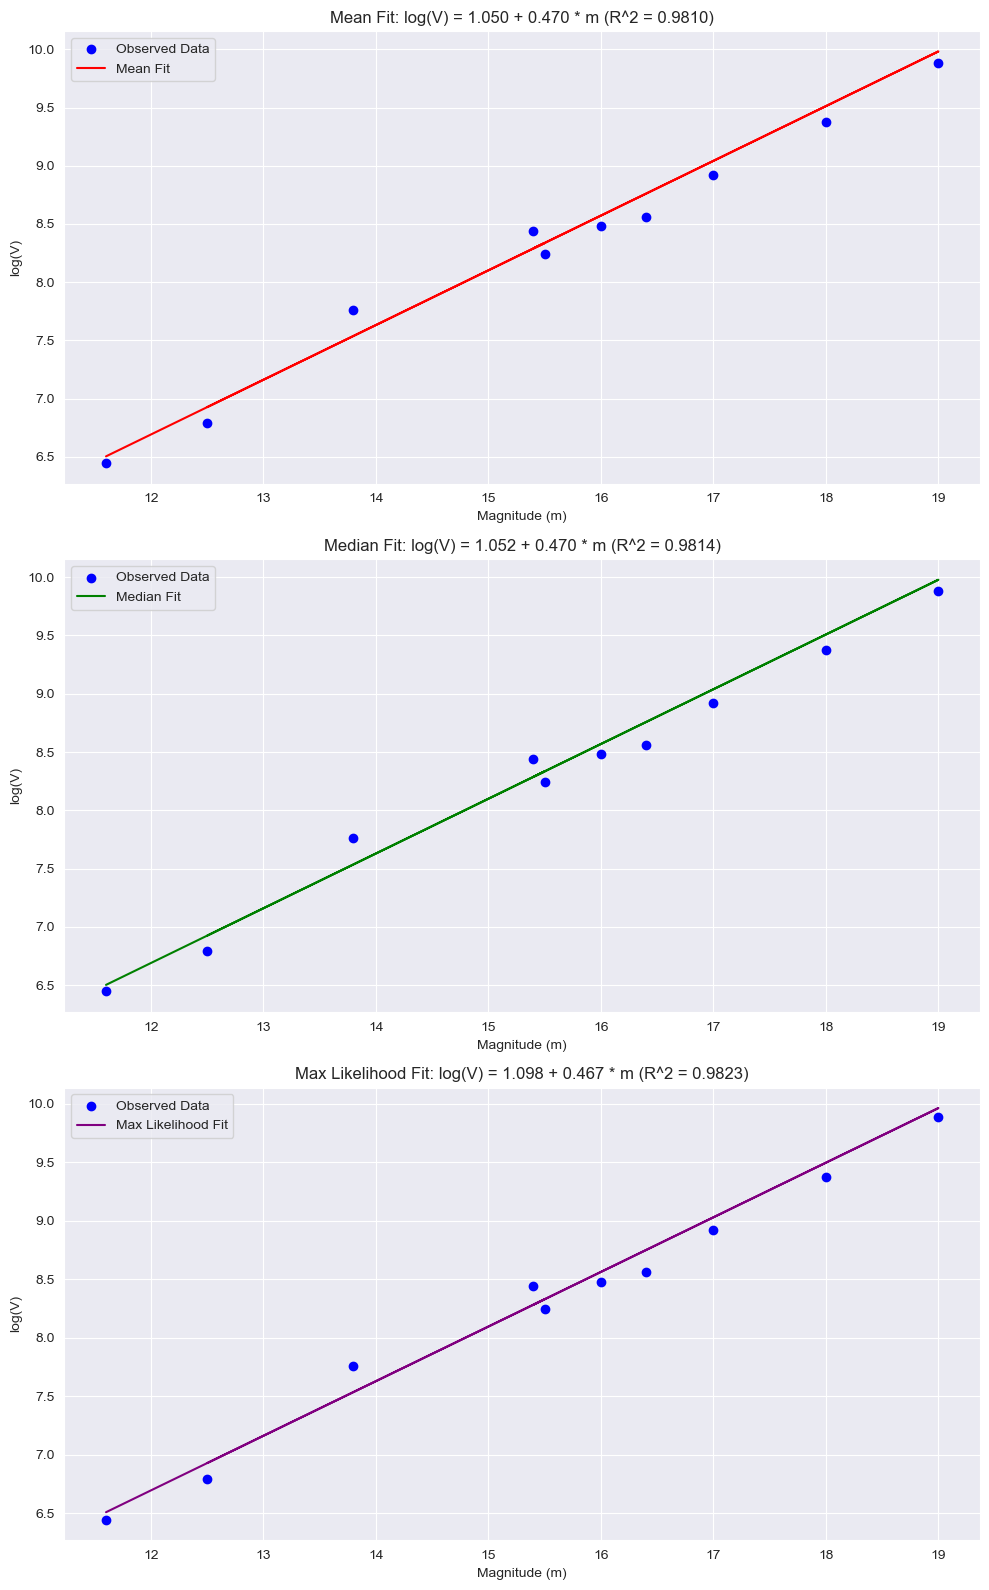

The best fit based on R^2 is the Max Likelihood model with R^2 = 0.9823.


In [75]:
# Function to calculate R^2
# Inputs:
#   a: intercept of the linear model
#   b: slope of the linear model
#   m: apparent magnitude data
#   log_v: observed log velocity data
def calculate_r_squared(a, b, m, log_v):
    log_v_pred = a + b * m  # Predicted log velocity based on linear model y = a + b * m
    ss_res = np.sum((log_v - log_v_pred) ** 2)  # Sum of squared residuals between observed and predicted values
    ss_tot = np.sum((log_v - np.mean(log_v)) ** 2)  # Total sum of squares based on deviation from mean
    return 1 - (ss_res / ss_tot)  # Calculate R^2 as 1 - (residual sum of squares / total sum of squares)

# Calculate R^2 values for the mean, median, and maximum likelihood estimates of parameters a and b
# Compute the mean, median, and maximum likelihood estimates for a and b based on the MCMC samples
a_mean, b_mean = np.mean(a_values), np.mean(b_values)  # Calculate mean estimates for a and b
a_median, b_median = np.median(a_values), np.median(b_values)  # Calculate median estimates for a and b
a_max_likelihood, b_max_likelihood = a_values[np.argmax(log_likelihoods)], b_values[np.argmax(log_likelihoods)]
# Find maximum likelihood estimates for a and b by locating the parameter values with the highest log-likelihood

# Calculate R^2 values for each set of estimates
r_squared_mean = calculate_r_squared(a_mean, b_mean, data["m"], log_v)  # R^2 for mean estimates
r_squared_median = calculate_r_squared(a_median, b_median, data["m"], log_v)  # R^2 for median estimates
r_squared_max_likelihood = calculate_r_squared(a_max_likelihood, b_max_likelihood, data["m"], log_v)  # R^2 for max likelihood estimates

# Print the calculated R^2 values for comparison
print(f"R^2 (Mean): {r_squared_mean}")
print(f"R^2 (Median): {r_squared_median}")
print(f"R^2 (Max Likelihood): {r_squared_max_likelihood}")

# Plotting the best-fit lines for each case: Mean, Median, and Max Likelihood
plt.figure(figsize=(10, 16))  # Set figure size to display each subplot clearly

# Mean fit
plt.subplot(3, 1, 1)  # Create the first subplot in a 3x1 grid layout
plt.scatter(data["m"], log_v, color="blue", label="Observed Data")  # Plot observed data points
plt.plot(data["m"], a_mean + b_mean * data["m"], color="red", label="Mean Fit")  # Plot mean fit line
plt.xlabel("Magnitude (m)")
plt.ylabel("log(V)")
plt.title(f"Mean Fit: log(V) = {a_mean:.3f} + {b_mean:.3f} * m (R^2 = {r_squared_mean:.4f})")  # Display mean fit equation and R^2
plt.legend()  # Add legend to the subplot

# Median fit
plt.subplot(3, 1, 2)  # Create the second subplot in a 3x1 grid layout
plt.scatter(data["m"], log_v, color="blue", label="Observed Data")  # Plot observed data points
plt.plot(data["m"], a_median + b_median * data["m"], color="green", label="Median Fit")  # Plot median fit line
plt.xlabel("Magnitude (m)")
plt.ylabel("log(V)")
plt.title(f"Median Fit: log(V) = {a_median:.3f} + {b_median:.3f} * m (R^2 = {r_squared_median:.4f})")  # Display median fit equation and R^2
plt.legend()  # Add legend to the subplot

# Maximum likelihood fit
plt.subplot(3, 1, 3)  # Create the third subplot in a 3x1 grid layout
plt.scatter(data["m"], log_v, color="blue", label="Observed Data")  # Plot observed data points
plt.plot(data["m"], a_max_likelihood + b_max_likelihood * data["m"], color="purple", label="Max Likelihood Fit")  # Plot max likelihood fit line
plt.xlabel("Magnitude (m)")
plt.ylabel("log(V)")
plt.title(f"Max Likelihood Fit: log(V) = {a_max_likelihood:.3f} + {b_max_likelihood:.3f} * m (R^2 = {r_squared_max_likelihood:.4f})")
plt.legend()  # Add legend to the subplot

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()  # Display the plot with all subplots

# Determine the best-fit model based on the highest R^2 value and print the result
best_r_squared = max(r_squared_mean, r_squared_median, r_squared_max_likelihood)
if best_r_squared == r_squared_mean:
    best_fit = "Mean"
elif best_r_squared == r_squared_median:
    best_fit = "Median"
else:
    best_fit = "Max Likelihood"

print(f"The best fit based on R^2 is the {best_fit} model with R^2 = {best_r_squared:.4f}.")


### Auto correlation of a and b 

To analyze this in a quantitative way, we calculate the autocorrelation of the parameter \( \theta_i \) at the \( i \)-th iteration as follows:

\begin{equation}
\rho_k = \frac{\sum_{t=k+1}^n (\theta_t - \bar{\theta})(\theta_{t-k}-\bar{\theta})}{\sum_{t=1}^n (\theta_t-\bar{\theta})^2}
\end{equation}

This equation expresses the correlation between values of a time series separated by a specific lag \( k \), indicating how each value in the series is related to preceding values. In this context, the terms in the equation are defined as:

- $ \rho_k $: autocorrelation at lag \( k \)
- $\theta_t $: value of the series at time \( t \)
- $\bar{\theta} $: mean of the series
- $ n $: number of observations


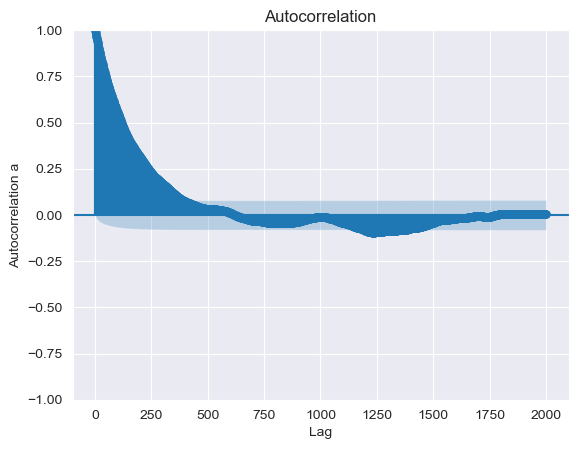

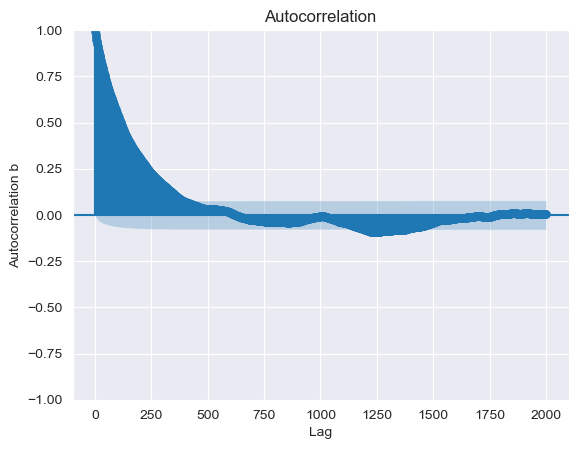

In [76]:
import statsmodels.api as sm  # Importing the statsmodels library for autocorrelation plotting

# Plot the autocorrelation function (ACF) for a_values with up to 2000 lags
sm.graphics.tsa.plot_acf(a_values, lags=2000)  # This function plots the ACF for the data in 'a_values' over 2000 lags
plt.xlabel('Lag')  # Labeling the x-axis as 'Lag' to indicate the time steps or delays
plt.ylabel('Autocorrelation a')  # Labeling the y-axis for 'a' values autocorrelation
# Note: This creates a new figure but will be overwritten by the next plot unless plt.show() is called

# Plot the autocorrelation function (ACF) for b_values with up to 2000 lags
sm.graphics.tsa.plot_acf(b_values, lags=2000)  # This function plots the ACF for the data in 'b_values' over 2000 lags
plt.xlabel('Lag')  # Labeling the x-axis as 'Lag' to indicate the time steps or delays
plt.ylabel('Autocorrelation b')  # Labeling the y-axis for 'b' values autocorrelation

plt.show()  # Display all the plots. plt.show() is required to display the graphs after labeling



According to the auto correlation plots it is shown that the auto-correlation by increasing the lag will exponentially decrease.